## Lewis and Gabriel

In this lab, we will be constructing and comparing various deep neural networks using Keras on the MNIST and MNIST Fashion datasets. 

First things first, we need to import the necessary libraries for our task. For this lab, we will be sticking to Keras (particularly the Tensorflow-Keras flavor) for as many tasks as possible. Since we're using Google Colab, the installation has already been taken care of.

In [ ]:
import tensorflow as tf
print("TensorFlow version:", tf.__version__)
import tensorflow.keras as keras 
print("Keras Version: ", keras.__version__)
import numpy as np # we'll need this for data preprocessing 

TensorFlow version: 2.6.0
Keras Version:  2.6.0


Next, lets import the standard MNIST dataset. MNIST contains grayscale images of handwritten digits (0-9). This dataset is a very popular benchmarking dataset and is frequently used as a "sanity check" to validate new machine learning techniques. 

MNIST is a multi-class classification dataset which means there are more than 2 classes (there are 10, exactly), and we can only classify one class as positive (as opposed to multi-label learning, which can have multiple positive classes).

In [ ]:
mnist = tf.keras.datasets.mnist #change this line for fashion MNIST

#this dataset is already split into training and testing sets
(x_train, y_train), (x_test, y_test) = mnist.load_data()
x_train, x_test = x_train / 255.0, x_test / 255.0

# Make sure images have shape (28, 28, 1)
x_train = np.expand_dims(x_train, -1)
x_test = np.expand_dims(x_test, -1)

print("x_train.shape = ", x_train.shape)
print("y_train.shape = ", y_train.shape)
print("x_test.shape = ", x_test.shape)
print("y_test.shape = ", y_test.shape)


# The labels are currently a single array of values
# We need to convert this into a one-hot encoded array
# i.e., 5 -> [0,0,0,0,0,1,0,0,0,0]
# We'll see why in a few cells

y_train_categorical = keras.utils.to_categorical(y_train)
y_test_categorical = keras.utils.to_categorical(y_test)
print("y_train.shape = ", y_train.shape)
print("y_test.shape = ", y_test.shape)


11501568/11490434 [==============================] - 0s 0us/step
x_train.shape =  (60000, 28, 28, 1)
y_train.shape =  (60000,)
x_test.shape =  (10000, 28, 28, 1)
y_test.shape =  (10000,)
y_train.shape =  (60000,)
y_test.shape =  (10000,)


The training set contains 60,000 images that are 28x28 pixels-squared and the testing set contains 10,000 images that are 28x28 pixels-squared. 

With the data loaded, let's construct a "simple" feed-forward neural network and train it as a baseline.

In [ ]:
def create_ff_baseline():
  # this layer flattens the input from (28x28) to an array of 784
  # this is the only model that requires this step
  ff_baseline = keras.Sequential(keras.layers.Flatten(input_shape=(28, 28)))
  ff_baseline.add(keras.layers.Dense(100, activation="relu", name="hidden"))
  ff_baseline.add(keras.layers.Dense(10, activation='softmax', name='classification'))
  return ff_baseline

ff_baseline = create_ff_baseline()
# Keras requires models to be "compiled" before they can be viewed or trained
ff_baseline.compile(optimizer="adam", #standard optimizer
                    loss="categorical_crossentropy", #standard for multi-class problems
                    metrics=["accuracy"])
# Print a textual summary of the model
ff_baseline.summary()
# Train the model - we will use the output of this function  later
ff_baseline_history = ff_baseline.fit(x=x_train, 
                                      y=y_train_categorical, 
                                      epochs=15,
                                      validation_split=0.1)

# Evaluate the model.
# We'll just evaluate accuracy for now. Later we'll abstract this to its own function
# and evaluate accuracy, f1, and area under the ROC curve 
predictions_ff_baseline = ff_baseline.predict(x_test)
# Convert the categorical predictions back to labels for calculating metrics
predictions_ff_baseline = [np.argmax(pred) for pred in predictions_ff_baseline]
m = tf.keras.metrics.Accuracy()
m.update_state(y_test, predictions_ff_baseline)
print(m.result().numpy())

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten (Flatten)            (None, 784)               0         
_________________________________________________________________
hidden (Dense)               (None, 100)               78500     
_________________________________________________________________
classification (Dense)       (None, 10)                1010      
Total params: 79,510
Trainable params: 79,510
Non-trainable params: 0
_________________________________________________________________
Epoch 1/15
1688/1688 [==============================] - 5s 2ms/step - loss: 0.2831 - accuracy: 0.9191 - val_loss: 0.1270 - val_accuracy: 0.9643
Epoch 2/15
1688/1688 [==============================] - 4s 2ms/step - loss: 0.1267 - accuracy: 0.9625 - val_loss: 0.1004 - val_accuracy: 0.9728
Epoch 3/15
1688/1688 [==============================] - 4s 2ms/step - loss: 0.0887 - accuracy:

Let's revisit this model, and add a callback. A callback is a function that performs some task at the end of each epoch. In our case, we are going to add a check to see if the model has overfit and end training if it has. This is called EarlyStopping.

More callbacks can be found https://keras.io/api/callbacks/

In [ ]:
ff_baseline_es = create_ff_baseline()
# we are setting up the early stopping mechanism to monitor validation loss, and should
# it reach an minima and attempt to start climbing (a sign of overfitting), stop the training
es = tf.keras.callbacks.EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=5)

# Keras requires models to be "compiled" before they can be viewed or trained
ff_baseline_es.compile(optimizer="adam", #standard optimizer
                    loss="categorical_crossentropy", #standard for multi-class problems
                    metrics=["accuracy"])
# Print a textual summary of the model
ff_baseline_es.summary()
# Train the model - we will use the output of this function  later
ff_baseline_es_history = ff_baseline_es.fit(x=x_train, 
                                      y=y_train_categorical, 
                                      epochs=200,
                                      validation_split=0.1,
                                      callbacks=[es]) #note the addition of the callback

# Evaluate the model.
# We'll just evaluate accuracy for now. Later we'll abstract this to its own function
# and evaluate accuracy, f1, and area under the ROC curve 
predictions_ff_baseline = ff_baseline_es.predict(x_test)
# Convert the categorical predictions back to labels for calculating metrics
predictions_ff_baseline = [np.argmax(pred) for pred in predictions_ff_baseline]
m = tf.keras.metrics.Accuracy()
m.update_state(y_test, predictions_ff_baseline)
print(m.result().numpy())

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_1 (Flatten)          (None, 784)               0         
_________________________________________________________________
hidden (Dense)               (None, 100)               78500     
_________________________________________________________________
classification (Dense)       (None, 10)                1010      
Total params: 79,510
Trainable params: 79,510
Non-trainable params: 0
_________________________________________________________________
Epoch 1/200
1688/1688 [==============================] - 4s 2ms/step - loss: 0.2970 - accuracy: 0.9156 - val_loss: 0.1477 - val_accuracy: 0.9603
Epoch 2/200
1688/1688 [==============================] - 4s 2ms/step - loss: 0.1396 - accuracy: 0.9589 - val_loss: 0.1132 - val_accuracy: 0.9703
Epoch 3/200
1688/1688 [==============================] - 4s 2ms/step - loss: 0.0979 - accu

Now, let's create a simple convolutional neural net (CNN) that has 3 hidden layers. CNNs extract spatial features based on the values of surrounding pixels. This makes them powerful for image classification tasks compared to feed-forward/dense neural networks.

In [ ]:

def create_simple_cnn():
  input_shape = (28,28,1)

  simple_cnn = keras.Sequential()
  simple_cnn.add(keras.layers.Conv2D(10, input_shape=input_shape, kernel_size=(3,3), strides=(1,1), padding='same', activation='relu'))
  simple_cnn.add(keras.layers.Conv2D(50, kernel_size=(3,3), strides=(1,1), padding='same', activation='relu'))
  simple_cnn.add(keras.layers.MaxPool2D(pool_size=(2,2)))
  simple_cnn.add(keras.layers.Dropout(0.25))
  simple_cnn.add(keras.layers.Flatten())
  simple_cnn.add(keras.layers.Dense(500, activation='relu'))
  simple_cnn.add(keras.layers.Dense(10, activation='softmax'))
  return simple_cnn

simple_cnn = create_simple_cnn()
simple_cnn.compile(optimizer="adam", #standard optimizer
                    loss="categorical_crossentropy", #standard for multi-class problems
                    metrics=["accuracy"])
simple_cnn.summary()

simple_cnn_history = simple_cnn.fit(x=x_train, 
                                    y=y_train_categorical, 
                                    epochs=5,
                                    validation_split=0.1)

# Evaluate the model.
# We'll just evaluate accuracy for now. Later we'll abstract this to its own function
# and evaluate accuracy, f1, and area under the ROC curve 
predictions_simple_cnn = simple_cnn.predict(x_test)
# Convert the categorical predictions back to labels for calculating metrics
predictions_simple_cnn = [np.argmax(pred) for pred in predictions_simple_cnn]
m = tf.keras.metrics.Accuracy()
m.update_state(y_test, predictions_simple_cnn)
print(m.result().numpy())

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 28, 28, 10)        100       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 28, 28, 50)        4550      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 14, 14, 50)        0         
_________________________________________________________________
dropout (Dropout)            (None, 14, 14, 50)        0         
_________________________________________________________________
flatten_2 (Flatten)          (None, 9800)              0         
_________________________________________________________________
dense (Dense)                (None, 500)               4900500   
_________________________________________________________________
dense_1 (Dense)              (None, 10)               

Next, we will examine the output of the fit functions that we saved earlier. The fit function returns a dictionary of training and validation accuracy that we can plot for evaluation purposes.

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])
Feed-Forward Baseline: 


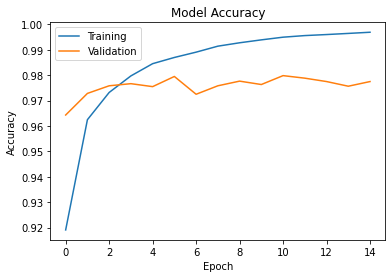

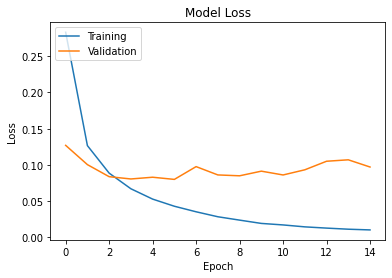

Feed-Forward Baseline with EarlyStopping: 


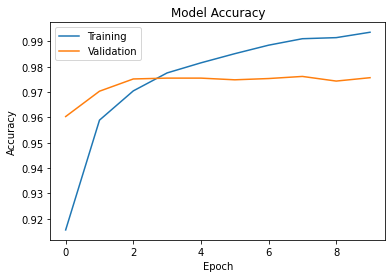

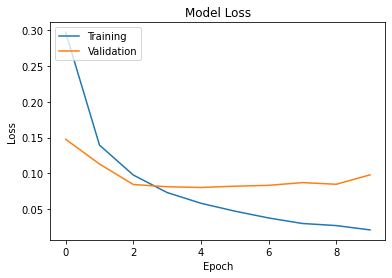

Simple CNN:


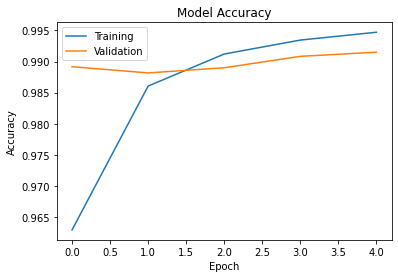

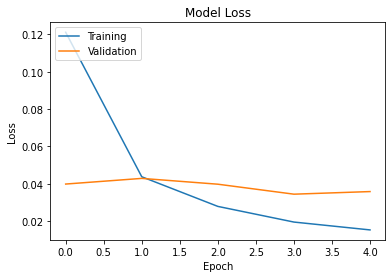

In [ ]:
import matplotlib.pyplot as plt
print(ff_baseline_history.history.keys())
# print(simple_cnn_history)

def visualize_training(history_dict):
  plt.plot(history_dict['accuracy'])
  plt.plot(history_dict['val_accuracy'])
  plt.title('Model Accuracy')
  plt.ylabel('Accuracy')
  plt.xlabel('Epoch')
  plt.legend(['Training', 'Validation'], loc='upper left')
  plt.show()
  # summarize history for loss
  plt.plot(history_dict['loss'])
  plt.plot(history_dict['val_loss'])
  plt.title('Model Loss')
  plt.ylabel('Loss')
  plt.xlabel('Epoch')
  plt.legend(['Training', 'Validation'], loc='upper left')
  plt.show()

print("Feed-Forward Baseline: ")
visualize_training(ff_baseline_history.history)
print("Feed-Forward Baseline with EarlyStopping: ")
visualize_training(ff_baseline_es_history.history)
print("Simple CNN:")
visualize_training(simple_cnn_history.history)

Now, let's define a function that calculates accuracy, F1 score, and area under the ROC curve for the predictions given true labels. We'll use Scikit-learns functions for calculating this for convienence.

In [ ]:
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score

def calculate_metrics(y_true, y_pred):
  # y_true: array of labels that are not one-hot encoded
  # y_pred: array of neural network outputs. One 10-element array of probabilities per image 
  y_pred_labels = [np.argmax(pred) for pred in y_pred]
  accuracy = accuracy_score(y_true=y_true, y_pred = y_pred_labels)
  f1 = f1_score(y_true=y_true, y_pred = y_pred_labels, average='macro')
  encoded = tf.keras.utils.to_categorical(y_true)
  roc_auc = roc_auc_score(y_true=encoded, y_score = y_pred, multi_class='ovr')

  return {"Accuracy": accuracy, "F1": f1, "AUC": roc_auc}

predictions_ff_baseline = ff_baseline.predict(x_test)
predictions_ff_baseline_es = ff_baseline_es.predict(x_test)
predictions_simple_cnn = simple_cnn.predict(x_test)
print("Feed-Forward Baseline: ", calculate_metrics(y_true=y_test, y_pred=predictions_ff_baseline))
print("Feed-Forward Baseline w/ Early Stopping: ", calculate_metrics(y_true=y_test, y_pred=predictions_ff_baseline_es))
print("Simple CNN: ", calculate_metrics(y_true=y_test, y_pred=predictions_simple_cnn) )

Feed-Forward Baseline:  {'Accuracy': 0.9781, 'F1': 0.9779470429371798, 'AUC': 0.9996094185596827}
Feed-Forward Baseline w/ Early Stopping:  {'Accuracy': 0.9738, 'F1': 0.9736680125276616, 'AUC': 0.9995057665143456}
Simple CNN:  {'Accuracy': 0.9891, 'F1': 0.9889399145597432, 'AUC': 0.9999489167610938}


# Assignment
Your turn: With the information available in this lab, create your own convolutional neural network that has better performance than the simple CNN demonstrated earlier. 

Resources:
- Layers API https://keras.io/api/layers/
- Compile Documentation https://keras.io/api/models/model_training_apis/ 
- Optimization Functions https://keras.io/api/optimizers/

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_2 (Conv2D)            (None, 28, 28, 10)        100       
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 28, 28, 50)        4550      
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 28, 28, 75)        33825     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 14, 14, 75)        0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 14, 14, 75)        0         
_________________________________________________________________
flatten_3 (Flatten)          (None, 14700)             0         
_________________________________________________________________
dense_2 (Dense)              (None, 600)              

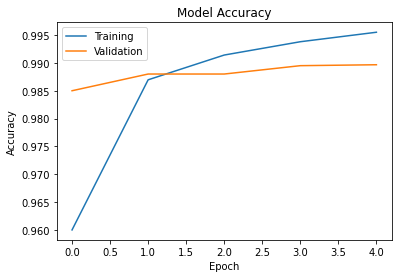

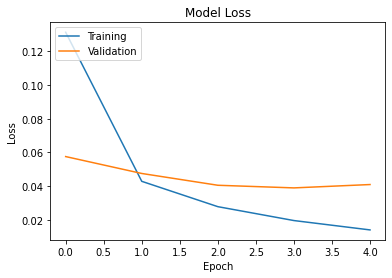

Custom CNN:  {'Accuracy': 0.9904, 'F1': 0.9903494242162323, 'AUC': 0.99995426253567}


In [ ]:
def create_custom_CNN():
  # For you to complete
  input_shape = (28,28,1)
  
  custom_cnn = keras.Sequential()
  custom_cnn.add(keras.layers.Conv2D(10, input_shape=input_shape, kernel_size=(3,3), strides=(1,1), padding='same', activation='relu'))
  custom_cnn.add(keras.layers.Conv2D(50, kernel_size=(3,3), strides=(1,1), padding='same', activation='relu'))
  custom_cnn.add(keras.layers.Conv2D(75, kernel_size=(3,3), strides=(1,1), padding='same', activation='relu'))
  custom_cnn.add(keras.layers.MaxPool2D(pool_size=(2,2)))
  custom_cnn.add(keras.layers.Dropout(0.25))
  custom_cnn.add(keras.layers.Flatten())
  custom_cnn.add(keras.layers.Dense(600, activation='relu'))
  custom_cnn.add(keras.layers.Dense(10, activation='softmax'))
  return custom_cnn

# modify below with callbacks
custom_CNN = create_custom_CNN()

# select the appropriate parameters for the compile function
custom_CNN.compile(optimizer="Adamax",
                   loss="categorical_crossentropy",
                   metrics=["accuracy"])
custom_CNN.summary()

custom_CNN_hist = custom_CNN.fit(x=x_train, 
                                    y=y_train_categorical, 
                                    epochs=5,
                                    validation_split=0.1)

visualize_training(custom_CNN_hist.history)

predictions_custom = custom_CNN.predict(x_test)
print("Custom CNN: ", calculate_metrics(y_true=y_test, y_pred=predictions_custom))

**Extra Information:** There are several pre-built neural network architectures available in Keras for image processing. Although it is very overkill for the MNIST data, let's walk through how to use the VGG16 architecture for this problem

In [ ]:
# First, we need to resize the images to 32x32
vgg16_xtrain = [np.expand_dims(np.pad(np.resize(x, (28,28)), ((2,2),(2,2))), -1) for x in x_train]
vgg16_xtrain = np.asarray(vgg16_xtrain)
print(vgg16_xtrain.shape)

vgg16_xtest = [np.expand_dims(np.pad(np.resize(x, (28,28)), ((2,2),(2,2))), -1) for x in x_test]
vgg16_xtest = np.asarray(vgg16_xtest)
print(vgg16_xtest.shape)

def create_vgg16():
  model = tf.keras.applications.VGG16(
                                      include_top=True, #include the fully-connected classification layers
                                      weights=None, # cannot use pre-trained weights for this custom task
                                      input_shape=(32,32,1),
                                      classes=10)
  return model


vgg16_mdl = create_vgg16()
vgg16_mdl.compile(optimizer="adam", #standard optimizer
                    loss="categorical_crossentropy", #standard for multi-class problems
                    metrics=["accuracy"])
vgg16_mdl.summary()

vgg16_mdl_history = vgg16_mdl.fit(x=vgg16_xtrain, 
                                    y=y_train_categorical, 
                                    epochs=1,
                                    validation_split=0.1)

# Evaluate the model.
# We'll just evaluate accuracy for now. Later we'll abstract this to its own function
# and evaluate accuracy, f1, and area under the ROC curve 
predictions_vgg16_mdl = vgg16_mdl.predict(vgg16_xtrain)
print("VGG 16: ", calculate_metrics(y_true=y_test, y_pred=predictions_vgg16_mdl) )
visualize_training(vgg16_mdl_history.history)

(60000, 32, 32, 1)
(10000, 32, 32, 1)
Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 32, 32, 1)]       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 32, 32, 64)        640       
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 32, 32, 64)        36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 16, 16, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 16, 16, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 16, 16, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling

ValueError: ignored